In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

# the main library has a small set of functionality
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)


%load_ext autoreload
%autoreload 2

/Users/jmontague/.virtualenvs/py35/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


We'll use some of the data that comes pre-packaged with `statsmodels` to demonstrate the library functionality. The data set below comprises incomplete, daily measurements of CO2 levels in Hawaii. 

In [2]:
dataset = sm.datasets.co2.load_pandas()
obs = dataset.data

obs.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


Because it's based on some existing `statsmodels` functionality, `STLDecompose` requires two things of the input dataframe:
1. continuous observations (no missing data points)
2. a `pandas` `DateTimeIndex`

Since these are both very situation-dependent, we leave it to the user to define how they want to acheive these goals - `pandas` provides a number of ways [to work with missing data](https://pandas.pydata.org/pandas-docs/stable/missing_data.html). In particular, the functions shown below make these steps relatively straightforward. Below, we add use linear interpolation, and resample to daily observations. The resulting frame meets both of our criteria. 

In [3]:
obs = (obs
       .resample('D')
       .mean()
       .interpolate('linear'))

obs.head(10)

,co2
1958-03-29,316.100000
1958-03-30,316.271429
1958-03-31,316.442857
1958-04-01,316.614286
1958-04-02,316.785714
1958-04-03,316.957143
1958-04-04,317.128571
1958-04-05,317.300000
1958-04-06,317.342857
1958-04-07,317.385714


In [4]:
obs.index

DatetimeIndex(['1958-03-29', '1958-03-30', '1958-03-31', '1958-04-01',
               '1958-04-02', '1958-04-03', '1958-04-04', '1958-04-05',
               '1958-04-06', '1958-04-07',
               ...
               '2001-12-20', '2001-12-21', '2001-12-22', '2001-12-23',
               '2001-12-24', '2001-12-25', '2001-12-26', '2001-12-27',
               '2001-12-28', '2001-12-29'],
              dtype='datetime64[ns]', length=15982, freq='D')

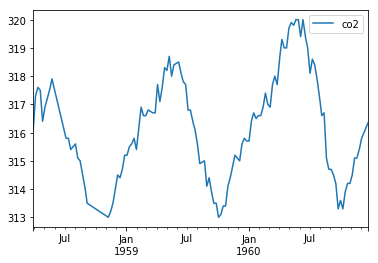

In [5]:
obs.head(1000).plot()

# Decompose

One of the primary pieces of functionality is the STL decomposition. The associated method requires the observation frame, and the primary (largest) period of seasonality. This `period` is in terms of index positions, and so care is needed for the user to correctly specify the periodicity in terms of their observations.

For example, with daily observations and large annual cycles, `period=365`. For hourly observations with large daily cycles, `period=24`. Some inspection, and trial and error may be helpful.

In [6]:
stl = decompose(obs, period=365)

stl

The resulting object is an extended version of the `statsmodels.tsa.seasonal.DecomposeResult`. Like the `statsmodels` object, the arrays of values are available on the object (the observations; and the trend, seasonal, and residual components). An extra attribute (the avergage seasonal cycle) has been added for the purpose of forecasting. 

We inherit the built-in `.plot()` method on the object.

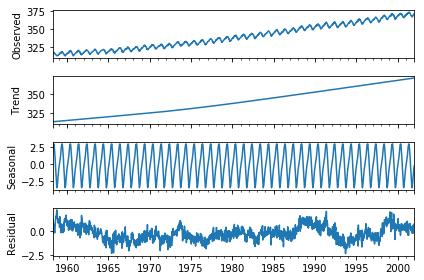

In [7]:
stl.plot();

# Forecast

While the STL decomposition is interesting on it's own, `STLDecompose` also provides some relatively naive capabilities for using the decomposition to forecast based on our observations. 

We'll use the same data set, but pretend that we only had the first two third of observations. Then we can compare our forecast to the real observation data. 

In [8]:
len(obs)

15982

In [9]:
short_obs = obs.head(10000)

In [10]:
# apply the decomp to the truncated observation
short_stl = decompose(short_obs, period=365)

short_stl

The `forecast()` method requires the following arguments:
- the fit `DecomposeResult`
- the number of steps forward for which we'd like the forecast
- the specific forecasting function we'll apply to the decomposition

There are a handful of predefined functions that can be imported from the `stldecompose.forecast_funcs` module. These implementations are based on [Hyndman's online textbook](https://www.otexts.org/fpp/2/3). The user can also define their own forecast function, following the patterns demonstrated in the predefined functions. 

The return type of the `forecast()` method is a `pandas.Dataframe` with a column name that represents the forecast function and an appropriate `DatetimeIndex`.

In [16]:
fcast = forecast(short_stl, steps=8000, fc_func=drift)

fcast.head()

,drift
1985-08-14,345.985881
1985-08-15,345.989898
1985-08-16,345.993915
1985-08-17,345.997933
1985-08-18,346.001950


If desired, we can then plot the corresponding components of the observation and forecast to check and verify the results.

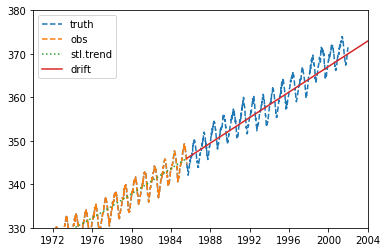

In [12]:
plt.plot(obs, '--', label='truth')
plt.plot(short_obs, '--', label='obs')
plt.plot(short_stl.trend, ':', label='stl.trend')
plt.plot(fcast, '-', label=fcast.columns[0])

plt.xlim('1970','2004'); plt.ylim(330,380);
plt.legend();

To include the estimated seasonal component in the forecast, use the boolean `seasonal` keyword.

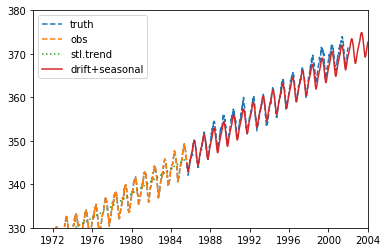

In [17]:
fcast = forecast(short_stl, steps=8000, fc_func=drift, seasonal=True)

plt.plot(obs, '--', label='truth')
plt.plot(short_obs, '--', label='obs')
plt.plot(short_stl.trend, ':', label='stl.trend')
plt.plot(fcast, '-', label=fcast.columns[0])

plt.xlim('1970','2004'); plt.ylim(330,380);
plt.legend();

In [18]:
fcast.head()

,drift+seasonal
1985-08-14,344.855165
1985-08-15,344.800451
1985-08-16,344.736606
1985-08-17,344.683039
1985-08-18,344.632911
